In [ ]:
from data.import_data import download_yf_data
rs = download_yf_data(['^HSI'], '2025-1-1','2025-11-14')
df = rs['^HSI'].reset_index()
print(df.head())
df.loc[len(df)-1,'Volume'] = df.iloc[-2]['Volume']
df

Price       Date          Open  ...         Close      Volume
0     2025-01-02  19932.800781  ...  19623.320312  4033400000
1     2025-01-03  19708.740234  ...  19760.269531  3393800000
2     2025-01-06  19848.710938  ...  19688.289062  2465700000
3     2025-01-07  19501.449219  ...  19447.580078  3581000000
4     2025-01-08  19390.759766  ...  19279.839844  3232400000

[5 rows x 6 columns]


/Users/menglu/Documents/trading-signal-streamlit-dashboard/data/import_data.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Price,Date,Open,High,Low,Close,Volume
0,2025-01-02,19932.800781,19932.800781,19542.980469,19623.320312,4033400000
1,2025-01-03,19708.740234,19891.859375,19634.070312,19760.269531,3393800000
2,2025-01-06,19848.710938,19851.550781,19627.839844,19688.289062,2465700000
3,2025-01-07,19501.449219,19668.650391,19252.609375,19447.580078,3581000000
4,2025-01-08,19390.759766,19483.589844,19111.539062,19279.839844,3232400000
...,...,...,...,...,...,...
210,2025-11-10,26319.400391,26668.890625,26302.929688,26649.060547,3124500000
211,2025-11-11,26748.089844,26788.429688,26511.250000,26696.410156,2417600000
212,2025-11-12,26754.929688,27016.400391,26739.089844,26922.730469,3437300000
213,2025-11-13,26779.480469,27188.810547,26733.210938,27073.029297,3285700000


2025-11-14 15:26:22,361 | 1780 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=8, host=127.0.0.1, port=11111, user_id=33457180
2025-11-14 15:30:04,420 | 1780 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=9, host=127.0.0.1, port=11111, user_id=33457180
2025-11-14 15:49:49,183 | 1780 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=10, host=127.0.0.1, port=11111, user_id=33457180
2025-11-14 16:09:34,322 | 1780 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=11, host=127.0.0.1, port=11111, user_id=33457180


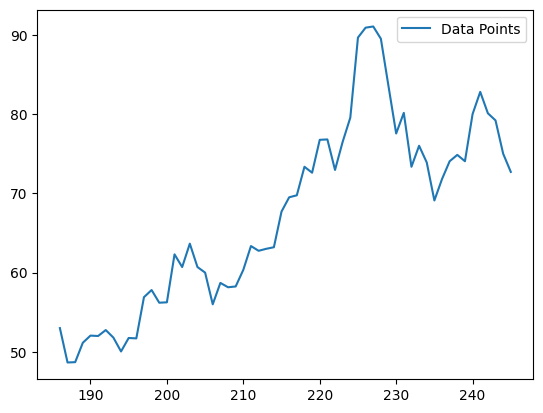

/var/folders/9x/bx7xlv0n3dng9qnrzlpnm52w0000gn/T/ipykernel_74536/1708861798.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x1, y1, 10)  # 1 for linear


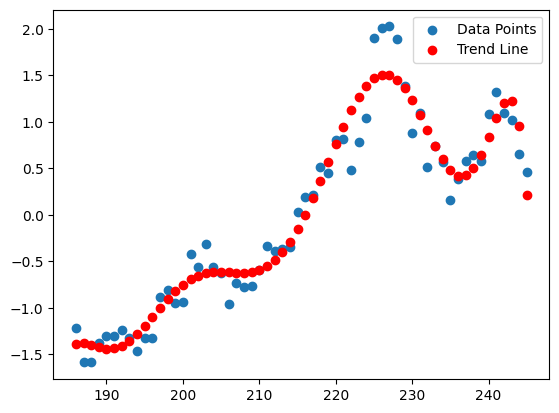

0.4540774636455089


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x= df.close.index.values
y= df.close.values.reshape(-1,1)


# Plotting
plt.plot(x[-60:], y[-60:], label='Data Points')
plt.legend()
plt.show()

#-------------------------------------
x1 = x[-60:]
y1 = scaler.fit_transform(y[-60:])
coefficients = np.polyfit(x1, y1, 10)  # 1 for linear
poly_fit = np.polyval(coefficients, x1)

# Plotting
plt.scatter(x1, y1, label='Data Points')
plt.plot(x1, poly_fit, color='red', label='Trend Line')
plt.legend()
plt.show()


print(np.sqrt(np.mean((y1[-10:] - poly_fit[-10:]) ** 2)))


2025-11-04 13:33:09,181 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=83, host=127.0.0.1, port=11111, user_id=33457180
刚刚呈现多头排列的日期：
Index([67, 72, 102, 197, 207], dtype='int64')


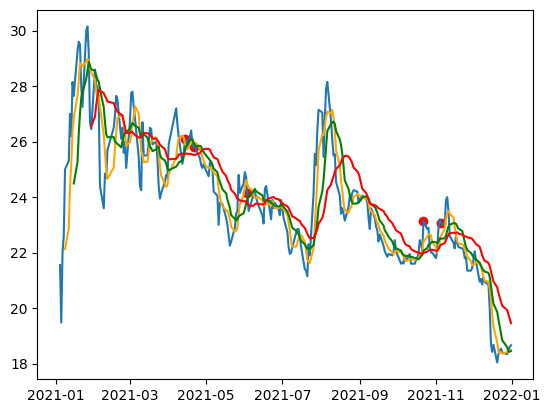

2025-11-04 15:22:51,807 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=84, host=127.0.0.1, port=11111, user_id=33457180
2025-11-04 15:22:51,812 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=85, host=127.0.0.1, port=11111, user_id=33457180
2025-11-04 15:22:51,816 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=86, host=127.0.0.1, port=11111, user_id=33457180
2025-11-04 15:22:51,817 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=87, host=127.0.0.1, port=11111, user_id=33457180
2025-11-04 15:22:51,818 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=88, host=127.0.0.1, port=11111, user_id=33457180
2025-11-04 15:40:44,166 | 74536 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=89, host=127.0.0.1, port=11111, user_id=33457180
2025-11-04 15:40:44,174 | 74536 | [open_contex

In [ ]:
import pandas as pd
from futu import *
import numpy as np

# 获取历史数据
def fetch_data(ticker, start, end):
    quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111) 
    ret, df, page_req_key = quote_ctx.request_history_kline('HK.0'+ticker, 
                                                            start=str(start), 
                                                            end= str(end), 
                                                            max_count= None, 
                                                            fields=[KL_FIELD.DATE_TIME,
                                                                    KL_FIELD.OPEN,
                                                                    KL_FIELD.HIGH,
                                                                    KL_FIELD.LOW,
                                                                    KL_FIELD.CLOSE,
                                                                    KL_FIELD.TRADE_VOL])
    if ret !=RET_OK:
        print('error: ', df)
    else:
        df = df.rename(columns={"time_key":"date"})
        df["date"] = pd.to_datetime(df["date"]).dt.date
    return df

# 计算移动平均线
def calculate_moving_averages(data, short_window=5, medium_window=10, long_window=20):
    data['Short_MA'] = data['close'].rolling(window=short_window).mean()
    data['Medium_MA'] = data['close'].rolling(window=medium_window).mean()
    data['Long_MA'] = data['close'].rolling(window=long_window).mean()
    return data

# 检测刚刚呈现多头排列
def check_recent_bullish_alignment(data):
    data['Bullish'] = (data['Short_MA'] > data['Medium_MA']) & (data['Medium_MA'] > data['Long_MA'])
    
    # 检测刚刚形成多头排列
    data['Turn_Bullish'] = (data['Bullish']) & ((~data['Bullish']).shift(1))
    sel_data = data[data.Turn_Bullish]['close']
    data['Just_Bullish'] = False
    id = sel_data[sel_data < sel_data.shift(1)].index
    data.loc[id,'Just_Bullish'] = True
    return data

# 主程序
if __name__ == "__main__":
    # 获取数据
    symbol = '0981'
    start_date = '2021-01-01'
    end_date = '2022-01-01'
    data = fetch_data(symbol, start_date, end_date)

    # 计算移动平均线
    data = calculate_moving_averages(data)

    # 检测刚刚呈现多头排列
    data = check_recent_bullish_alignment(data)

    # 输出结果
    recent_bullish_days = data[data['Just_Bullish']]
    print("刚刚呈现多头排列的日期：")
    print(recent_bullish_days.index)

    import matplotlib.pyplot as plt
    plt.plot(data.date, data.close)
    plt.plot(data.date, data.Short_MA, color='orange')
    plt.plot(data.date, data.Medium_MA, color='green')
    plt.plot(data.date, data.Long_MA, color='red')
    plt.scatter(data.date[recent_bullish_days.index], data.close[recent_bullish_days.index], color='r')

In [131]:
tmp = data.iloc[recent_bullish_days.index]
tmp['pct_change'] = tmp.close/tmp.Long_MA-1
tmp

/var/folders/9x/bx7xlv0n3dng9qnrzlpnm52w0000gn/T/ipykernel_74536/1980908532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['pct_change'] = tmp.close/tmp.Long_MA-1


,code,date,open,high,low,close,volume,Short_MA,Medium_MA,Long_MA,Bullish,Just_Bullish,pct_change
35,HK.00288,2024-02-22,3.37327,3.44327,3.33327,3.43327,19443102,3.33127,3.26127,3.24627,1,1,0.057605
46,HK.00288,2024-03-08,3.42327,3.73327,3.42327,3.57327,31328383,3.38927,3.35827,3.31527,1,1,0.077822
61,HK.00288,2024-04-02,3.85327,3.95327,3.80327,3.92327,48085356,3.76727,3.75627,3.68527,1,1,0.064581
75,HK.00288,2024-04-23,4.11327,4.37327,4.08327,4.35327,46193671,4.05327,4.04527,3.91877,1,1,0.110877
89,HK.00288,2024-05-14,4.48327,4.53327,4.36327,4.49327,29909052,4.33127,4.31327,4.24077,1,1,0.059541
133,HK.00288,2024-07-18,4.10327,4.33327,4.10327,4.19327,22685752,4.12327,3.96927,3.96777,1,1,0.056833
152,HK.00288,2024-08-14,4.22327,4.51327,4.22327,4.49327,74569870,4.13927,4.03527,3.99877,1,1,0.123663
163,HK.00288,2024-08-29,4.34327,4.48327,4.29327,4.47327,13383104,4.40527,4.38427,4.24027,1,1,0.054949
203,HK.00288,2024-10-30,5.28327,5.34327,5.11327,5.28327,31300922,5.20527,5.11927,5.10777,1,1,0.034359
218,HK.00288,2024-11-20,5.24327,5.38327,5.23327,5.33327,24842529,5.16127,5.11627,5.09627,1,1,0.046505


In [118]:
data.head()

,code,date,open,high,low,close,volume,Short_MA,Medium_MA,Long_MA,Bullish,Just_Bullish
0,HK.00981,2022-01-03,18.80,18.92,18.66,18.84,6902187,NaN,NaN,NaN,0,0
1,HK.00981,2022-01-04,18.90,18.94,18.42,18.60,24126370,NaN,NaN,NaN,0,0
2,HK.00981,2022-01-05,18.70,18.70,18.02,18.18,32615272,NaN,NaN,NaN,0,0
3,HK.00981,2022-01-06,18.04,18.48,17.98,18.30,30370273,NaN,NaN,NaN,0,0
4,HK.00981,2022-01-07,18.16,18.50,18.10,18.18,22727035,18.42,NaN,NaN,0,0


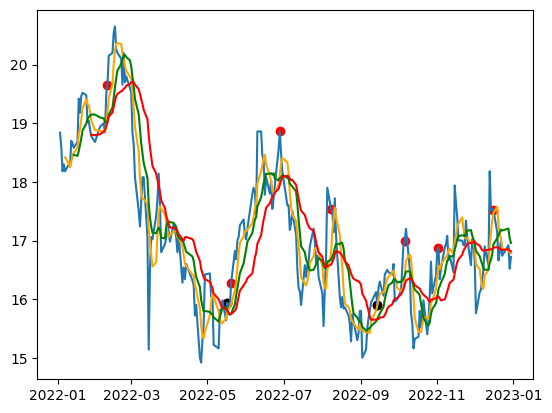

In [127]:
import matplotlib.pyplot as plt
plt.plot(data.date, data.close)
plt.plot(data.date, data.Short_MA, color='orange')
plt.plot(data.date, data.Medium_MA, color='green')
plt.plot(data.date, data.Long_MA, color='red')
plt.scatter(data.date[recent_bullish_days.index], data.close[recent_bullish_days.index], color='r')
plt.scatter(data.date[[88,171]],data.close[[88,171]],color='black')
plt.show()

In [49]:
from data.import_data import download_yf_data
rs = download_yf_data(['AAPL','NVDA'], start_date='2025-1-1')
df = rs['AAPL'].reset_index()
df.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close', 'Volume':'volume'},inplace=True)
df



/Users/menglu/Documents/trading-signal-streamlit-dashboard/data/import_data.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Price,date,open,high,low,close,volume
0,2025-01-02,247.809220,247.978468,240.731247,242.752106,55740700
1,2025-01-03,242.264297,243.080598,240.800915,242.264297,40244100
2,2025-01-06,243.210016,246.216423,242.105013,243.896912,45045600
3,2025-01-07,241.886014,244.444450,240.263363,241.119492,40856000
4,2025-01-08,240.830767,242.612716,238.969192,241.607254,37628900
...,...,...,...,...,...,...
212,2025-11-06,267.630574,273.135217,267.630574,269.508728,51204000
213,2025-11-07,269.538690,272.026299,266.511626,268.209991,48227400
214,2025-11-10,268.959991,273.730011,267.459991,269.429993,41312400
215,2025-11-11,269.809998,275.910004,269.799988,275.250000,46208300


In [164]:
70.4/69.7-1

0.010043041606886627

In [7]:
import requests
from dataclasses import dataclass
import datetime

@dataclass
class AlpacaConfig:
    API_KEY = 'PKO1ARBTPTA3QL7M5BF3'
    API_SECRET = 'bvSSDPdWcQkTNgtO2Fxdbznf1a8tqylrfQCPKanA'
    HEADERS = {
        'APCA-API-KEY-ID': API_KEY,
        'APCA-API-SECRET-KEY': API_SECRET
    }
    BARS_URL = 'https://data.alpaca.markets/v2/stocks'  # v1/bars
   


def get_price_from_alpaca(symbol, start:datetime, end:datetime, interval) -> list[dict]:
    config = AlpacaConfig()
    url = config.BARS_URL + '/bars'
    params = {"end": end} #int(end.timestamp() * 1000)
    params['symbols'] = symbol
    params["timeframe"] = interval
    params["start"] = start#int(start.timestamp() * 1000)
    params["limit"] = 1000

    response: list[list] = requests.get(url, params=params, headers=config.HEADERS).json()
    # url = config.BARS_URL+'/1Day?symbols=MSFT'
    # print(url)
    # response = requests.get(url, headers = config.HEADERS)
    print(response)
    

get_price_from_alpaca('AAPL', datetime.datetime(2025,1,1).date(),datetime.datetime.today().date(),interval='1D')

{'message': 'subscription does not permit querying recent SIP data'}


In [ ]:
from futu import *
quote_ctx = OpenQuoteContext(host='127.0.0.1', port=11111)
with open('./data/code_pool_hk.txt','r') as fp:
    code_pool = [line.rstrip() for line in fp]
code_list = ['HK.0'+code for code in code_pool]
ret, data = quote_ctx.get_owner_plate(code_list)
if ret != RET_OK:
    print('error:', data)
quote_ctx.close() # 结束后记得关闭当条连接，防止连接条数用尽

import pandas as pd
sector_mapping = pd.read_csv("./data/sector_mapping.csv")
df = data.set_index('plate_type').loc['INDUSTRY']
sector_df = df.merge(sector_mapping, on='plate_name', how='inner')


2025-11-18 12:39:54,390 | 19929 | [open_context_base.py] _send_init_connect_sync:311: InitConnect ok: conn_id=22, host=127.0.0.1, port=11111, user_id=33457180
2025-11-18 12:39:54,429 | 19929 | [open_context_base.py] on_disconnect:383: Disconnected: conn_id=22
object
object
                code    plate_code plate_name
plate_type                                   
INDUSTRY    HK.00700  HK.LIST23363   数码解决方案服务
INDUSTRY    HK.03690  HK.LIST23361      线上零售商
INDUSTRY    HK.01299   HK.LIST1003         保险
INDUSTRY    HK.09618  HK.LIST23361      线上零售商
INDUSTRY    HK.09633   HK.LIST1080      非酒精饮料
  plate_name                  sector
0   数码解决方案服务              Technology
1      线上零售商  Consumer Discretionary
2         保险              Financials
3      非酒精饮料        Consumer Staples
4       其他金融              Financials


,code,plate_code,plate_name,sector
0,HK.00700,HK.LIST23363,数码解决方案服务,Technology
1,HK.03690,HK.LIST23361,线上零售商,Consumer Discretionary
2,HK.01299,HK.LIST1003,保险,Financials
3,HK.09618,HK.LIST23361,线上零售商,Consumer Discretionary
4,HK.09633,HK.LIST1080,非酒精饮料,Consumer Staples
...,...,...,...,...
96,HK.02333,HK.LIST1040,汽车,Consumer Discretionary
97,HK.09868,HK.LIST1040,汽车,Consumer Discretionary
98,HK.02318,HK.LIST1003,保险,Financials
99,HK.00939,HK.LIST1079,银行,Financials


In [37]:
data.set_index('plate_type').loc['INDUSTRY'].plate_name.unique()

array(['数码解决方案服务', '线上零售商', '保险', '非酒精饮料', '其他金融', '酒精饮料', '地产发展商',
       '互动媒体及服务', '消费性电讯设备', '银行', '服装', '药品分销', '公共运输', '赌场及博彩', '综合企业',
       '生物技术', '半导体', '家庭电器', '航空货运及物流', '旅游及观光', '鞋类', '汽车', '其他零售商',
       '电讯服务', '常规电力', '卫星及无线通讯', '地产投资', '乳制品', '燃气供应', '非传统/可再生能源',
       '餐饮', '酒店及度假村', '采购及供应链管理', '电子零件', '汽车零售商', '药品', '航运及港口',
       '物业服务及管理', '消费电子产品', '新能源物料', '电脑及周边器材', '铝', '包装食品', '工业零件及器材',
       '建筑材料', '航空服务', '应用软件', '医疗设备及用品', '水务'], dtype=object)

In [38]:
data.set_index('plate_type').loc['INDUSTRY'].plate_name.nunique()

49